# Hybrid Image

Hybrid image is the sum of a low-pass filtered image and a high-pass filtered image.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_image(fname):
    gray_img = cv2.imread(fname, 0)    # gray image
    bgr_img = cv2.imread(fname)
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    return gray_img, rgb_img

In [3]:
def ideal_low_pass_filter(size_x, size_y, cutoff=0.5):
    H = np.zeros((size_x, size_y))
    center_x = int(size_x/2)
    center_y = int(size_y/2)
    for i in range(size_x):
        u = i-center_x
        for j in range(size_y):
            v = j-center_y
            H[i,j] = (u**2+v**2)**(1/2)
#     print("low-pass H: {0}\n{1}".format(H.shape, H))
    for i in range(size_x):
        for j in range(size_y):
            if H[i,j]<=cutoff:
                H[i,j]=1
            else:
                H[i,j]=0
#     print("low-pass-filter: {0}\n{1}".format(H.shape, H))
    return H

In [4]:
def ideal_high_pass_filter(size_x, size_y, cutoff=0.5):
    H = np.zeros((size_x, size_y))
    center_x = int(size_x/2)
    center_y = int(size_y/2)
    for i in range(size_x):
        u = i-center_x
        for j in range(size_y):
            v = j-center_y
            H[i,j] = (u**2+v**2)**(1/2)
#     H /= H[-1,-1]    # do the normalization
    print("high-pass H: {0}\n{1}".format(H.shape, H))
    for i in range(size_x):
        for j in range(size_y):
            if H[i,j]<=cutoff:
                H[i,j]=0
            else:
                H[i,j]=1
#     print("high-pass-filter: {0}\n{1}".format(H.shape, H))
    return H

In [5]:
def gaussian_low_pass_filter(size_x, size_y, cutoff=10):
    H = np.zeros((size_x, size_y))
    center_x = int(size_x/2)
    center_y = int(size_y/2)
    for i in range(size_x):
        u = i-center_x
        for j in range(size_y):
            v = j-center_y
            H[i,j] = np.exp(-(u**2+v**2)/(2*cutoff**2))
#     print("low-pass-filter: {0}\n{1}".format(H.shape, H))
    return H

In [6]:
def gaussian_high_pass_filter(size_x, size_y, cutoff=10):
    H = np.zeros((size_x, size_y))
    center_x = int(size_x/2)
    center_y = int(size_y/2)
    for i in range(size_x):
        u = i-center_x
        for j in range(size_y):
            v = j-center_y
            H[i,j] = 1-np.exp(-(u**2+v**2)/(2*cutoff**2))
#     print("high-pass-filter: {0}\n{1}".format(H.shape, H))
    return H

In [7]:
def get_magnitude_spectrum(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    return magnitude_spectrum, fshift

In [8]:
def plot_img(img_1, img_2, img_3, camp=None):
    fig, ax = plt.subplots(1,3, figsize=[10, 8])
    ax[0].imshow(img_1, cmap = camp)
    ax[1].imshow(img_2, cmap = camp)
    ax[2].imshow(img_3, cmap = camp)
    plt.tight_layout()

In [9]:
def filter_image(img, cutoff, low_pass=True, gaussian=True):
    magnitude_spectrum, fshift = get_magnitude_spectrum(img)
    if low_pass:
        if gaussian:
            f = gaussian_low_pass_filter(magnitude_spectrum.shape[0], magnitude_spectrum.shape[1], cutoff=cutoff)
        else:
            f = ideal_low_pass_filter(magnitude_spectrum.shape[0], magnitude_spectrum.shape[1], cutoff=cutoff)
    else:
        if gaussian:
            f = gaussian_high_pass_filter(magnitude_spectrum.shape[0], magnitude_spectrum.shape[1], cutoff=cutoff)
        else:
            f = ideal_high_pass_filter(magnitude_spectrum.shape[0], magnitude_spectrum.shape[1], cutoff=cutoff)
    out_magnitude = magnitude_spectrum * f
    output = fshift * f
    fshift  = np.fft.ifftshift(output)
    img_back = np.fft.ifft2(fshift)
    img_back = np.abs(img_back)
    return magnitude_spectrum, img_back, out_magnitude

In [10]:
def hybrid_gray(file_name_1, file_name_2):
    img_1, rgb_img_1 = read_image(file_name_1)
    magnitude_spectrum_1, img_back_1, out_magnitude_1 = filter_image(img_1, 20, low_pass=True, gaussian=True)
    img_2, rgb_img_2 = read_image(file_name_2)
    magnitude_spectrum_2, img_back_2, out_magnitude_2 = filter_image(img_2, 20, low_pass=False, gaussian=True)
    
    hybrid = img_back_1 + img_back_2
    hybrid_magnitude = out_magnitude_1 + out_magnitude_2
    
    plot_img(out_magnitude_1, out_magnitude_2, hybrid_magnitude, 'gray')
    plot_img(img_back_1, img_back_2, hybrid, 'gray')

In [11]:
def hybrid_rgb(file_name_1, file_name_2):
    img_1, rgb_img_1 = read_image(file_name_1)
    r1, g1, b1 = cv2.split(rgb_img_1)
    _, img_back_r1, _ = filter_image(r1, 20, low_pass=True, gaussian=True)
    _, img_back_g1, _ = filter_image(g1, 20, low_pass=True, gaussian=True)
    _, img_back_b1, _ = filter_image(b1, 20, low_pass=True, gaussian=True)
    img_2, rgb_img_2 = read_image(file_name_2)
    r2, g2, b2 = cv2.split(rgb_img_2)
    _, img_back_r2, _ = filter_image(r2, 20, low_pass=False, gaussian=True)
    _, img_back_g2, _ = filter_image(g2, 20, low_pass=False, gaussian=True)
    _, img_back_b2, _ = filter_image(b2, 20, low_pass=False, gaussian=True)
    
    img_back_r1 = img_back_r1.astype(int)
    img_back_g1 = img_back_g1.astype(int)
    img_back_b1 = img_back_b1.astype(int)
    img_back_1 = cv2.merge((img_back_r1, img_back_g1, img_back_b1))
    img_back_r2 = img_back_r2.astype(int)
    img_back_g2 = img_back_g2.astype(int)
    img_back_b2 = img_back_b2.astype(int)
    img_back_2 = cv2.merge((img_back_r2, img_back_g2, img_back_b2))
    hybrid = img_back_1 + img_back_2
    
    plot_img(img_back_1, img_back_2, hybrid, 'gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


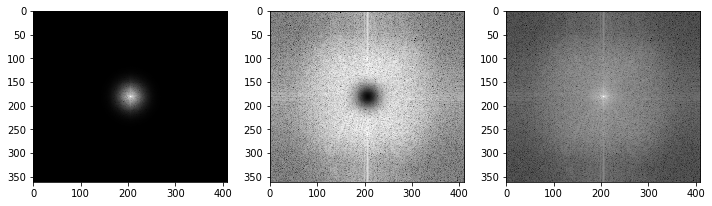

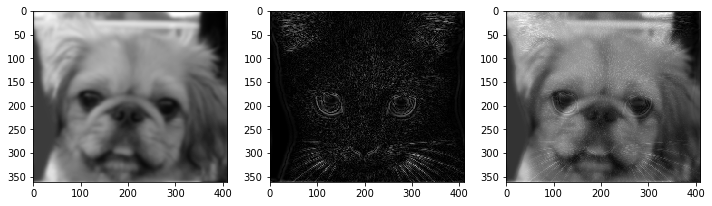

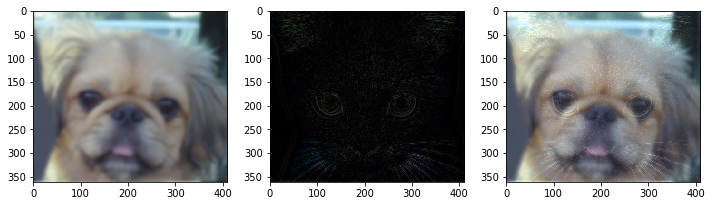

In [12]:
hybrid_gray('./hw2_data/task1and2_hybrid_pyramid/dog.bmp', './hw2_data/task1and2_hybrid_pyramid/cat.bmp')
hybrid_rgb('./hw2_data/task1and2_hybrid_pyramid/dog.bmp', './hw2_data/task1and2_hybrid_pyramid/cat.bmp')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


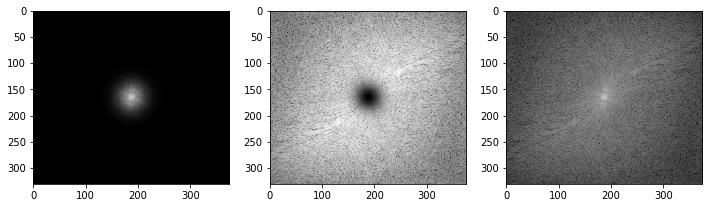

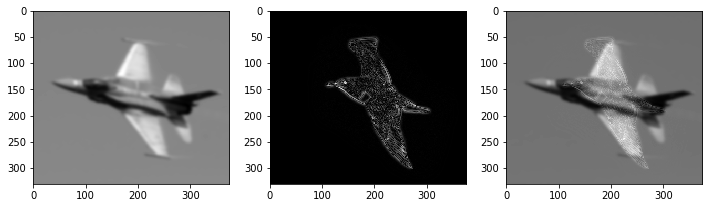

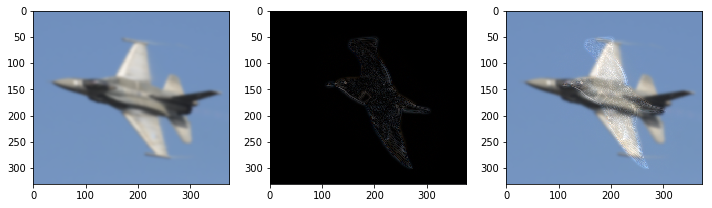

In [13]:
hybrid_gray('./hw2_data/task1and2_hybrid_pyramid/plane.bmp', './hw2_data/task1and2_hybrid_pyramid/bird.bmp')
hybrid_rgb('./hw2_data/task1and2_hybrid_pyramid/plane.bmp', './hw2_data/task1and2_hybrid_pyramid/bird.bmp')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


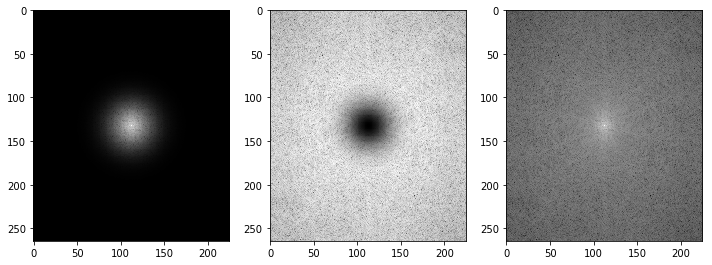

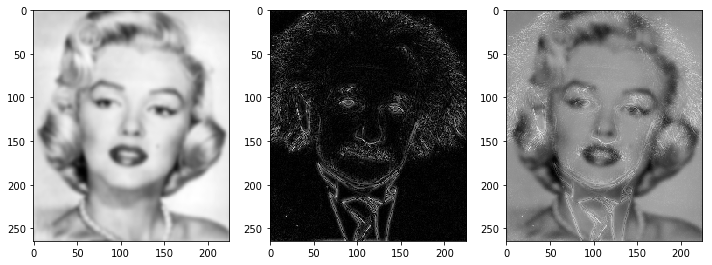

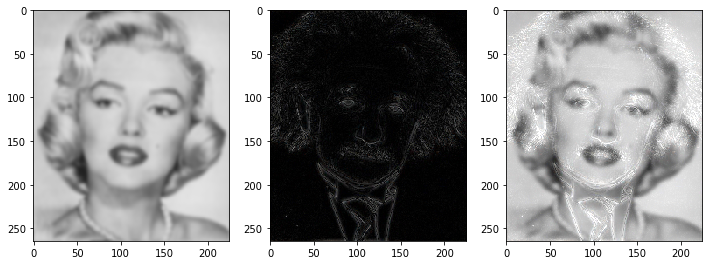

In [14]:
hybrid_gray('./hw2_data/task1and2_hybrid_pyramid/marilyn.bmp', './hw2_data/task1and2_hybrid_pyramid/einstein.bmp')
hybrid_rgb('./hw2_data/task1and2_hybrid_pyramid/marilyn.bmp', './hw2_data/task1and2_hybrid_pyramid/einstein.bmp')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


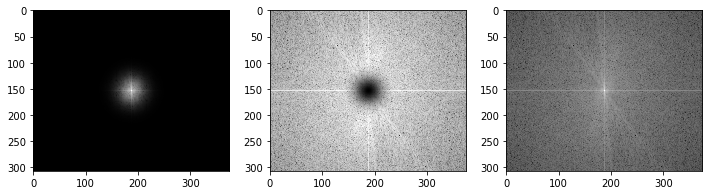

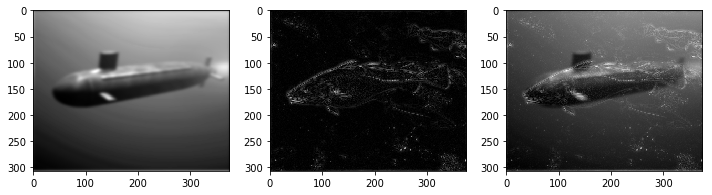

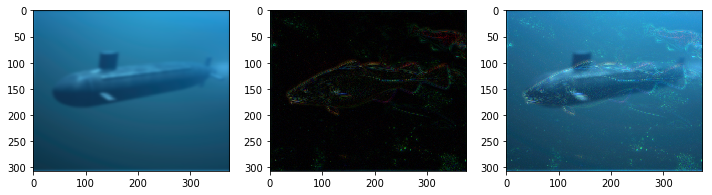

In [15]:
hybrid_gray('./hw2_data/task1and2_hybrid_pyramid/submarine.bmp', './hw2_data/task1and2_hybrid_pyramid/fish.bmp')
hybrid_rgb('./hw2_data/task1and2_hybrid_pyramid/submarine.bmp', './hw2_data/task1and2_hybrid_pyramid/fish.bmp')